In [1]:
%load_ext autoreload
%autoreload 1
%aimport models

from models import *

(Re)loading load_data
(Re)loading models


In [2]:
testBehav = behavior[(behavior.session=='experiment') & behavior.condType.isin(condTypes)]
usedTestSubjs = testBehav[~testBehav.excluded].subjectId.unique()
testTrials = testBehav[testBehav.subjectId.isin(usedTestSubjs)].set_index(['subjectId', 'session', 'trialCount'], verify_integrity=True)

In [3]:
pupils = samples.merge(testTrials, left_on=['subjectId', 'session', 'Trial'], right_index=True)
trialStart = pupils.groupby(['subjectId', 'session', 'Trial']).Time.min()
testTrials['CueStart'] = trialStart + pd.to_timedelta('2s')
testTrials['CueEnd'] = trialStart + pd.to_timedelta('6s')

In [4]:
blinksIndexed = blinks
blinksIndexed['Start_index'] = blinksIndexed.Start
blinksIndexed = blinks.set_index(['subjectId', 'session', 'Start_index'], verify_integrity=True).sort_index()

In [5]:
%%time
from collections import defaultdict
columns = defaultdict(list)
for _, row in testTrials.reset_index().iterrows():
    columns['subjectId'].append(row.subjectId)
    columns['session'].append(row.session)
    columns['trialCount'].append(row.trialCount)
    sessionBlinks = blinksIndexed.loc[row.subjectId, row.session]
    columns['blinkCount'].append(sessionBlinks.Start.between(row.CueStart, row.CueEnd).sum())
counts = pd.DataFrame(columns).set_index(['subjectId', 'session', 'trialCount'], verify_integrity=True)
testTrials['blinkRate'] = counts.blinkCount.astype(float) / ((testTrials.CueEnd - testTrials.CueStart) / pd.to_timedelta('1s'))

CPU times: total: 3.83 s
Wall time: 3.84 s


In [6]:
blinkRates = testTrials.reset_index().groupby(['subjectId', 'session', 'condType'], as_index=False).blinkRate.mean()

In [7]:
excSubjects = getExcSubjects()
blinkRates['excSubject'] = blinkRates.subjectId.isin(excSubjects)

Subjects not selecting the preferred option in more than half of both normal and wink trials:
	 [4006, 5008, 5015, 5033, 5034, 5038, 5041, 5047, 8001, 8006, 8016, 8020, 8021, 8025]


In [8]:
blinkRates['entropy'] = blinkRates.condType.apply(lambda c: 0. if c == 'hint' else 1. if c == 'blush' else 0.72)
blinkRates['kld'] = blinkRates.condType.apply(lambda c: 0. if c == 'normal' else 1.2 if c == 'wink' else 0.32)

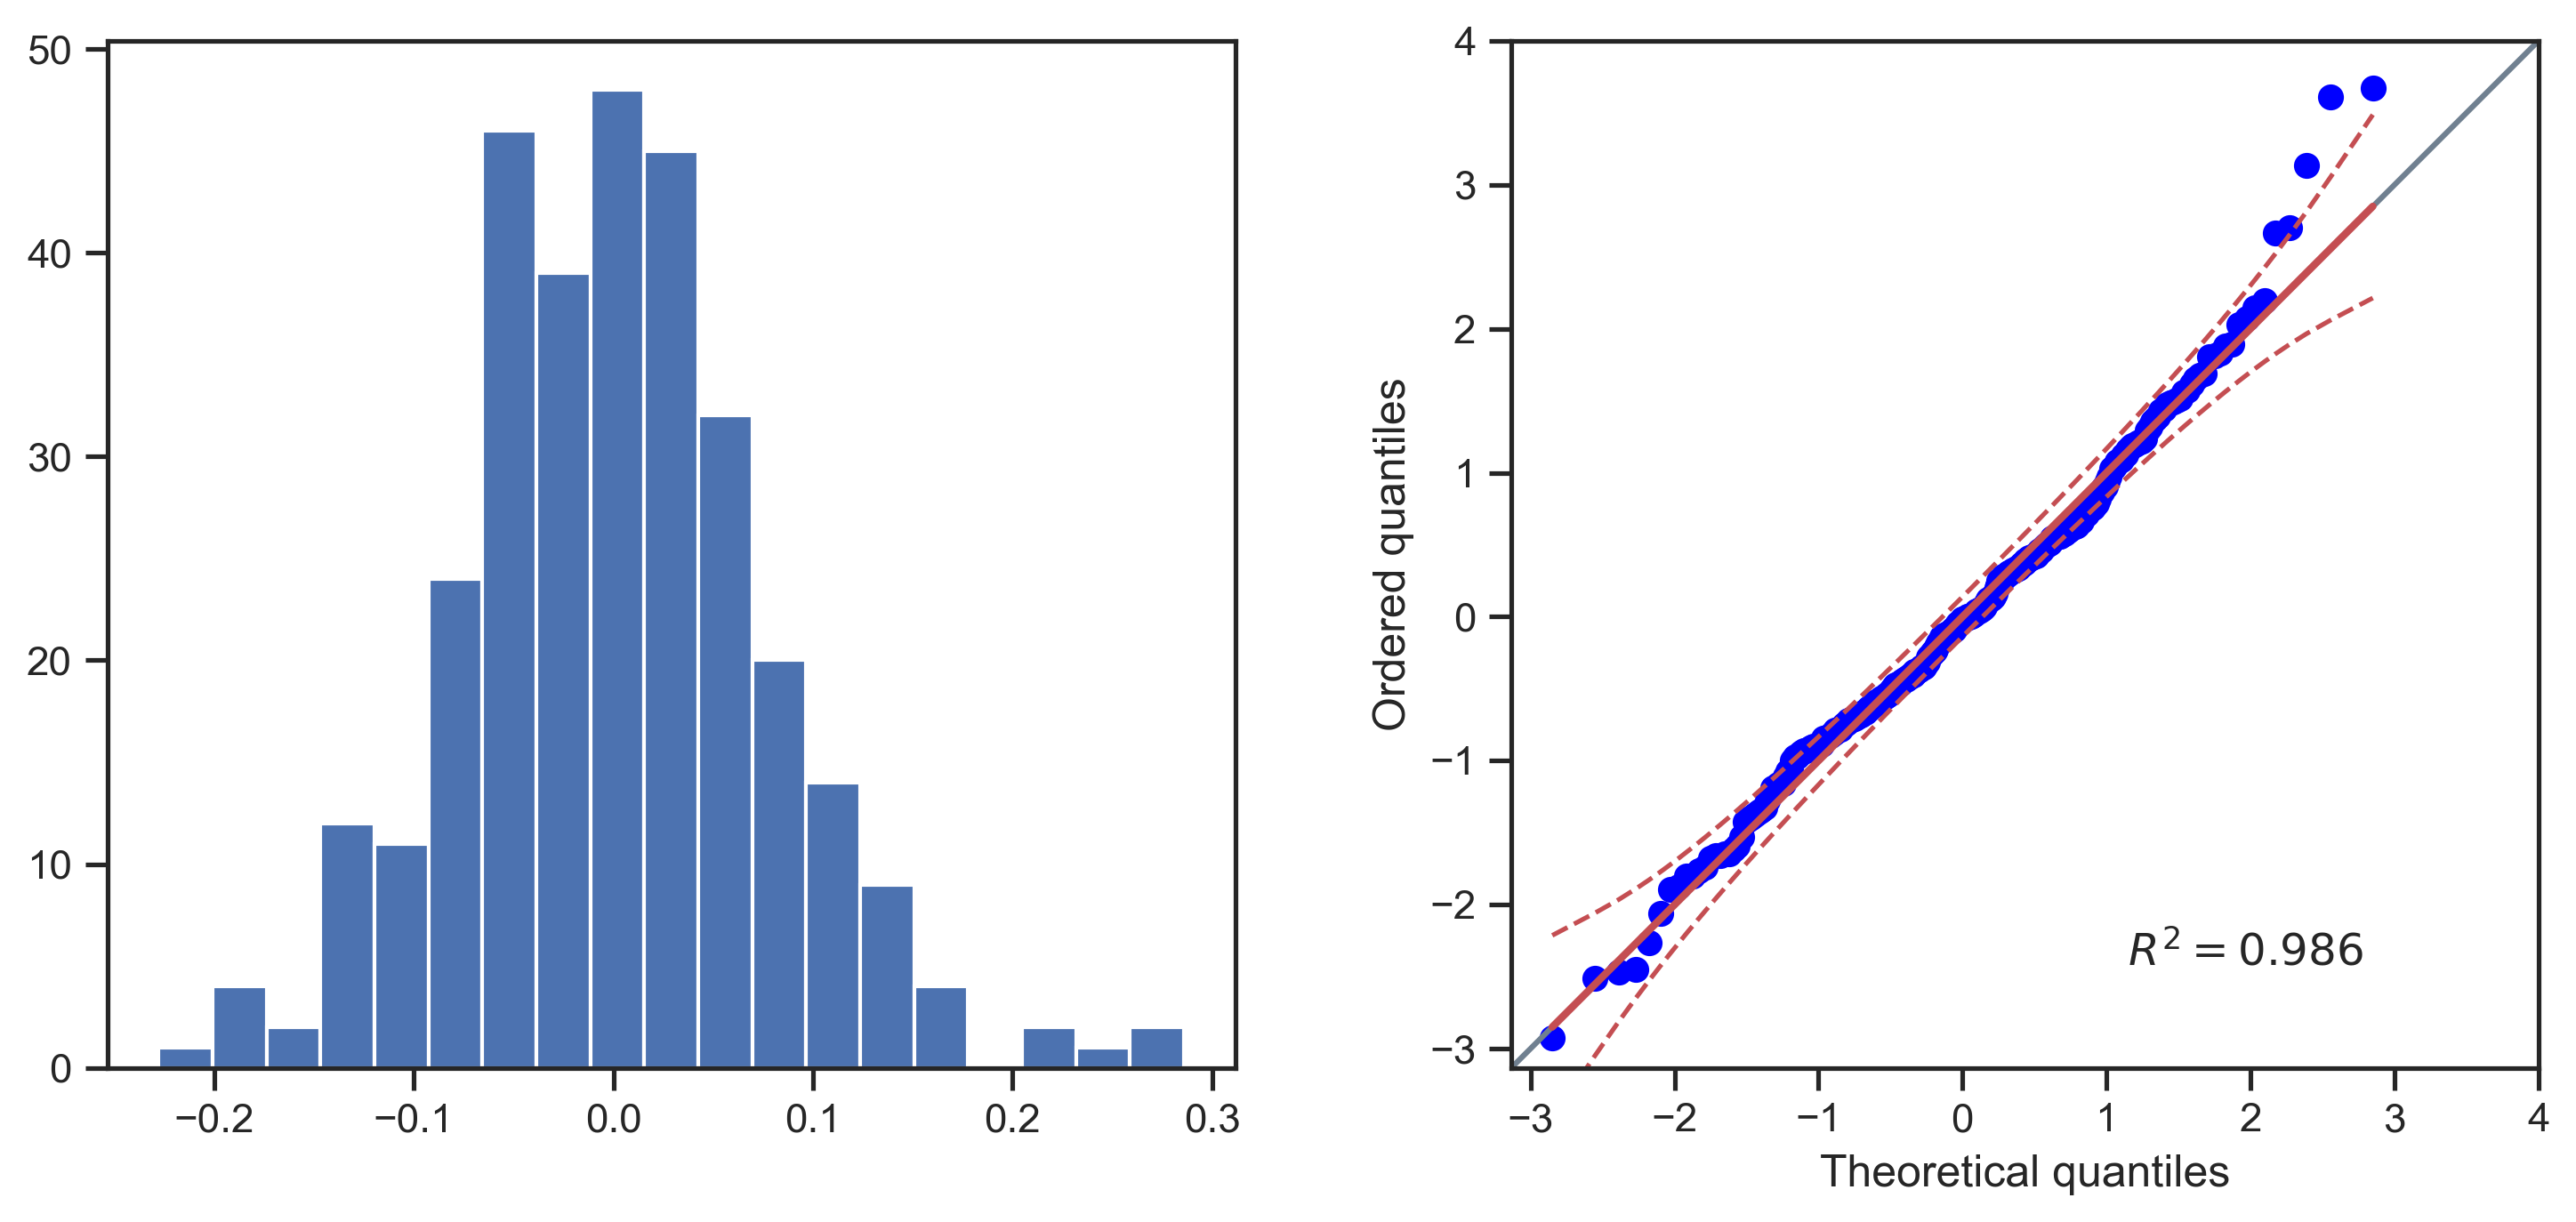

In [9]:
checkResiduals(smf.mixedlm('blinkRate ~ C(condType)', blinkRates, groups='subjectId'))

In [10]:
def compareBlinkRates(df):
    res = pg.rm_anova(df, dv='blinkRate', within='condType', subject='subjectId', effsize='np2')
    display(res)
    for cond1, cond2 in [('wink', 'normal'), ('blush', 'hint')]:
        res = pg.ttest(df.query('condType==@cond1').blinkRate, df.query('condType==@cond2').blinkRate, paired=True)
        display(res.style.set_caption(f'{cond1}-{cond2}'))   

In [11]:
compareBlinkRates(blinkRates.query('~excSubject'))

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,condType,3,192,4.050005,0.008057,0.059515,0.987511


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.679359,64,two-sided,0.499360,[-0.02 0.04],0.049185,0.17,0.067657


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.523193,64,two-sided,0.000793,[0.02 0.08],0.268884,32.143,0.569577


In [12]:
compareBlinkRates(blinkRates)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,condType,3,234,4.040375,0.007942,0.049249,0.988665


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.308970,78,two-sided,0.758168,[-0.02 0.03],0.019644,0.13,0.053414


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.519829,78,two-sided,0.000724,[0.02 0.08],0.242613,32.55,0.567448


In [13]:
def combinedBlinkPlot(data, saveAs=None, dv='blinkRate'):
    fig = plt.figure(figsize=(12, 5), dpi=300)
    ax1, ax2 = fig.subplots(nrows=1, ncols=2)
    
    condTypeBarChart(data, dv, ax=ax1)
    ax1.set_title('A) Blink rates by condition')
    ax1.set_ylabel('Blink rate [1/sec]')
    sigLabels(ax1, data, dv, sigLevel=None)

    models = createModels(dv, data)
    print(compareModels(models, ax=ax2))
    ax2.set_title('B) Bayesian weights of models explaining blink rates')
    
    plt.tight_layout()
    plt.rcParams['pdf.fonttype'] = 42
    if saveAs is not None:
        fig.savefig(os.path.join(output_dir, f'{saveAs}.png'))
        fig.savefig(os.path.join(output_dir, f'{saveAs}.pdf'))
    plt.show()

null->kld: Chi2Result(df=1, statistic=0.4570072952692499, pvalue=0.4990259490229533), B=12.830654208699716
null->entropy: Chi2Result(df=1, statistic=10.777469283149685, pvalue=0.0010274305896920712)
entropy->kldEntropy: Chi2Result(df=1, statistic=0.1493198910004594, pvalue=0.6991861437947409), B=14.964502103321458
entropy->condType: Chi2Result(df=2, statistic=1.1876755181490353, pvalue=0.5522039871256608), B=143.5730366526737
        model  relativeBIC  bayesWeight
0        null     5.216788     0.063869
1         kld    10.320462     0.004978
2     entropy     0.000000     0.867165
3  kldEntropy     5.411362     0.057948
4    condType     9.933688     0.006040


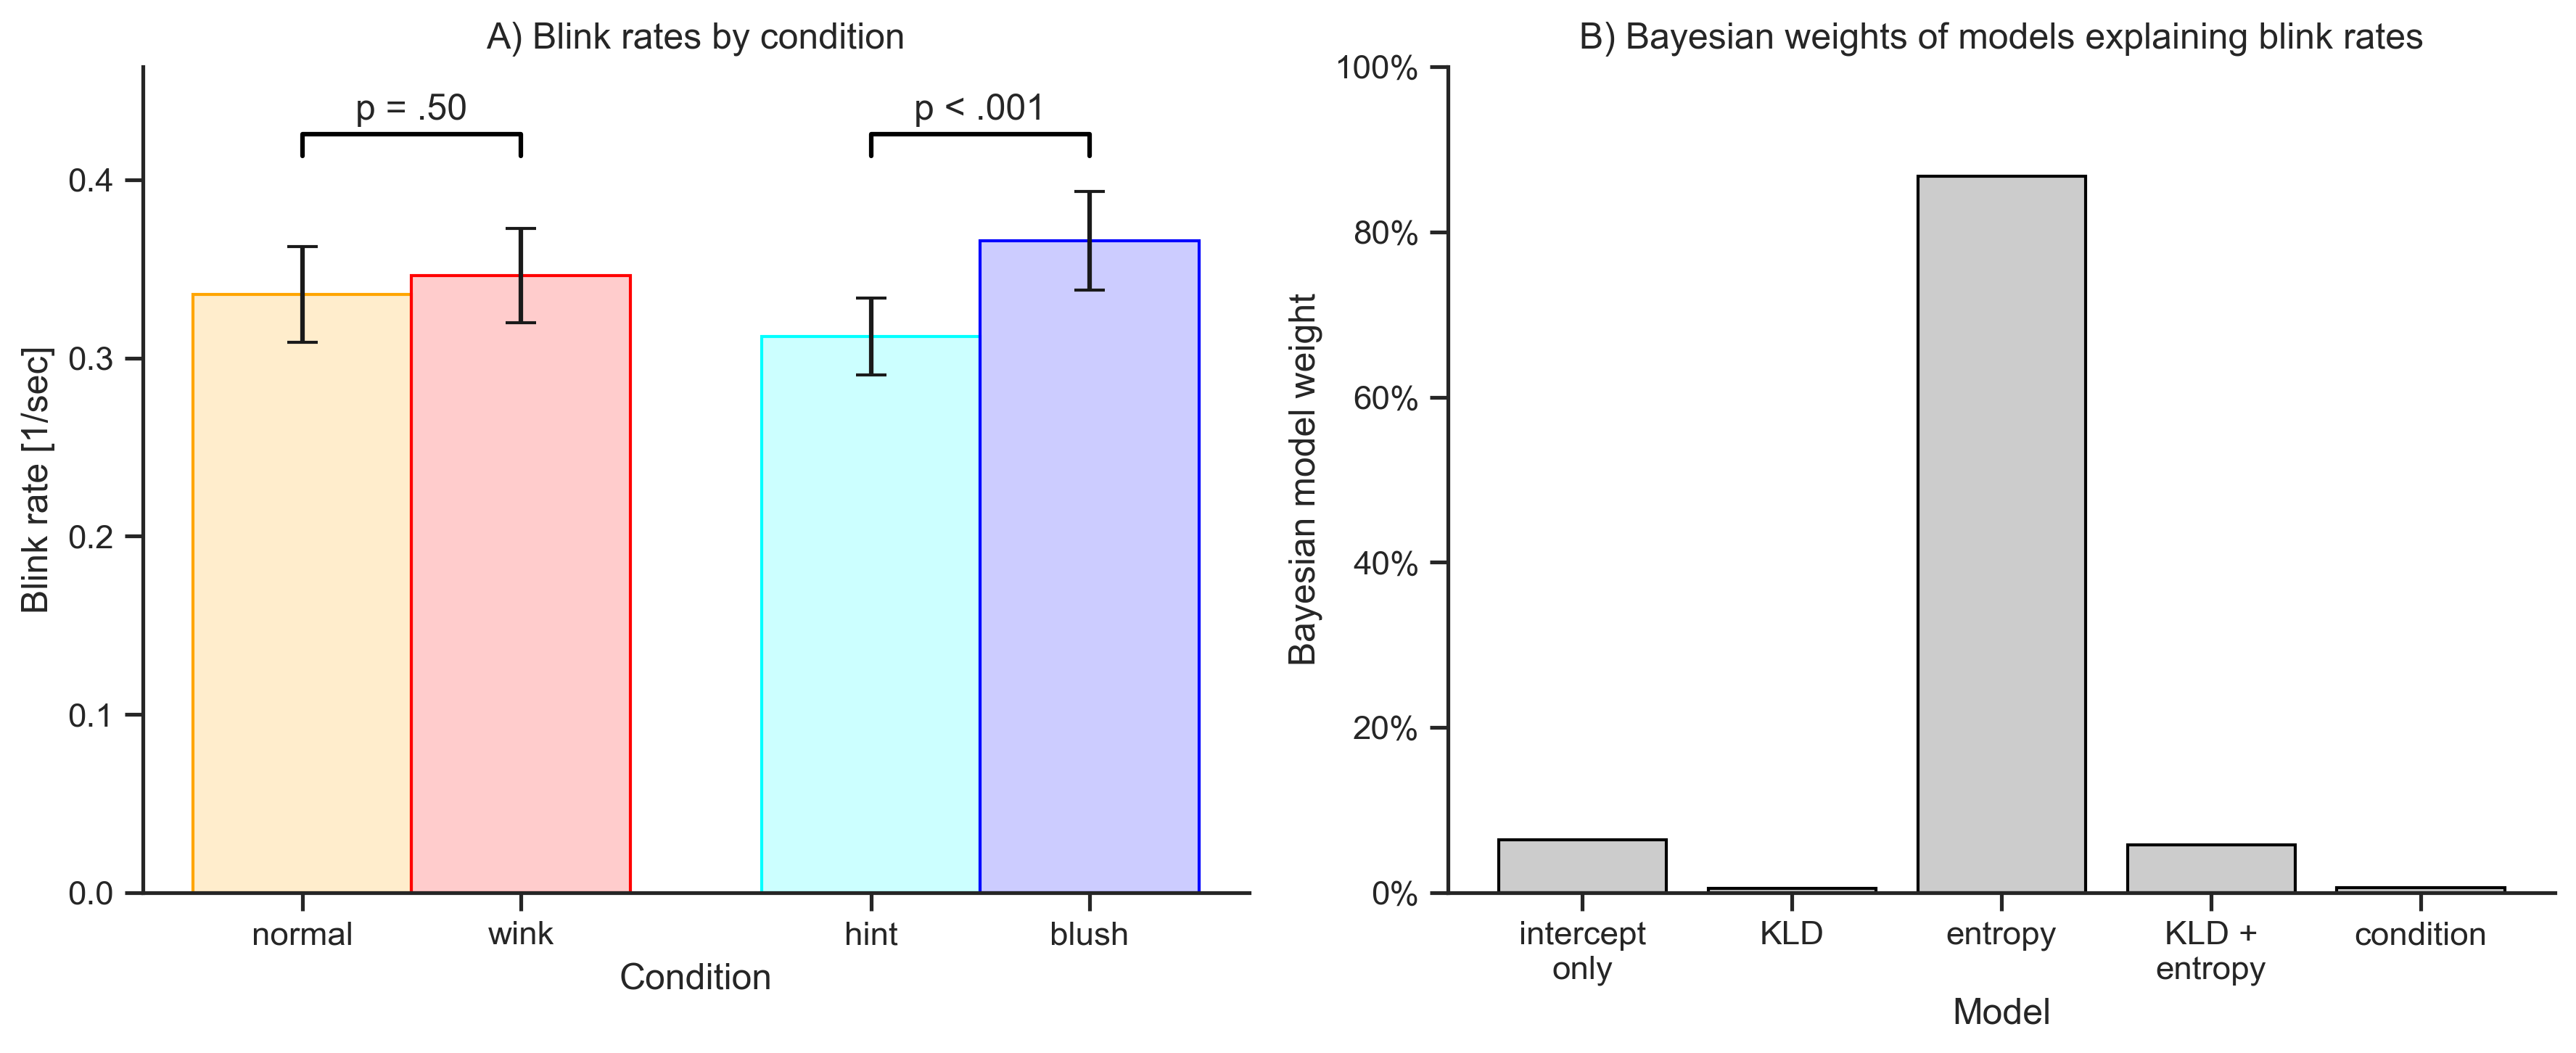

In [14]:
combinedBlinkPlot(blinkRates.query('~excSubject'), saveAs='figure7')

null->kld: Chi2Result(df=1, statistic=0.050056126315666916, pvalue=0.8229656385812419), B=17.33700169264398
null->entropy: Chi2Result(df=1, statistic=10.38349309693217, pvalue=0.001271469160216385)
entropy->kldEntropy: Chi2Result(df=1, statistic=0.005617089170527834, pvalue=0.9402566880831787), B=17.7265330978256
entropy->condType: Chi2Result(df=2, statistic=1.5856403705777211, pvalue=0.45256667198665634), B=143.01106834778142
        model  relativeBIC  bayesWeight
0        null     4.627751     0.084656
1         kld    10.333437     0.004883
2     entropy     0.000000     0.856175
3  kldEntropy     5.750125     0.048299
4    condType     9.925844     0.005987


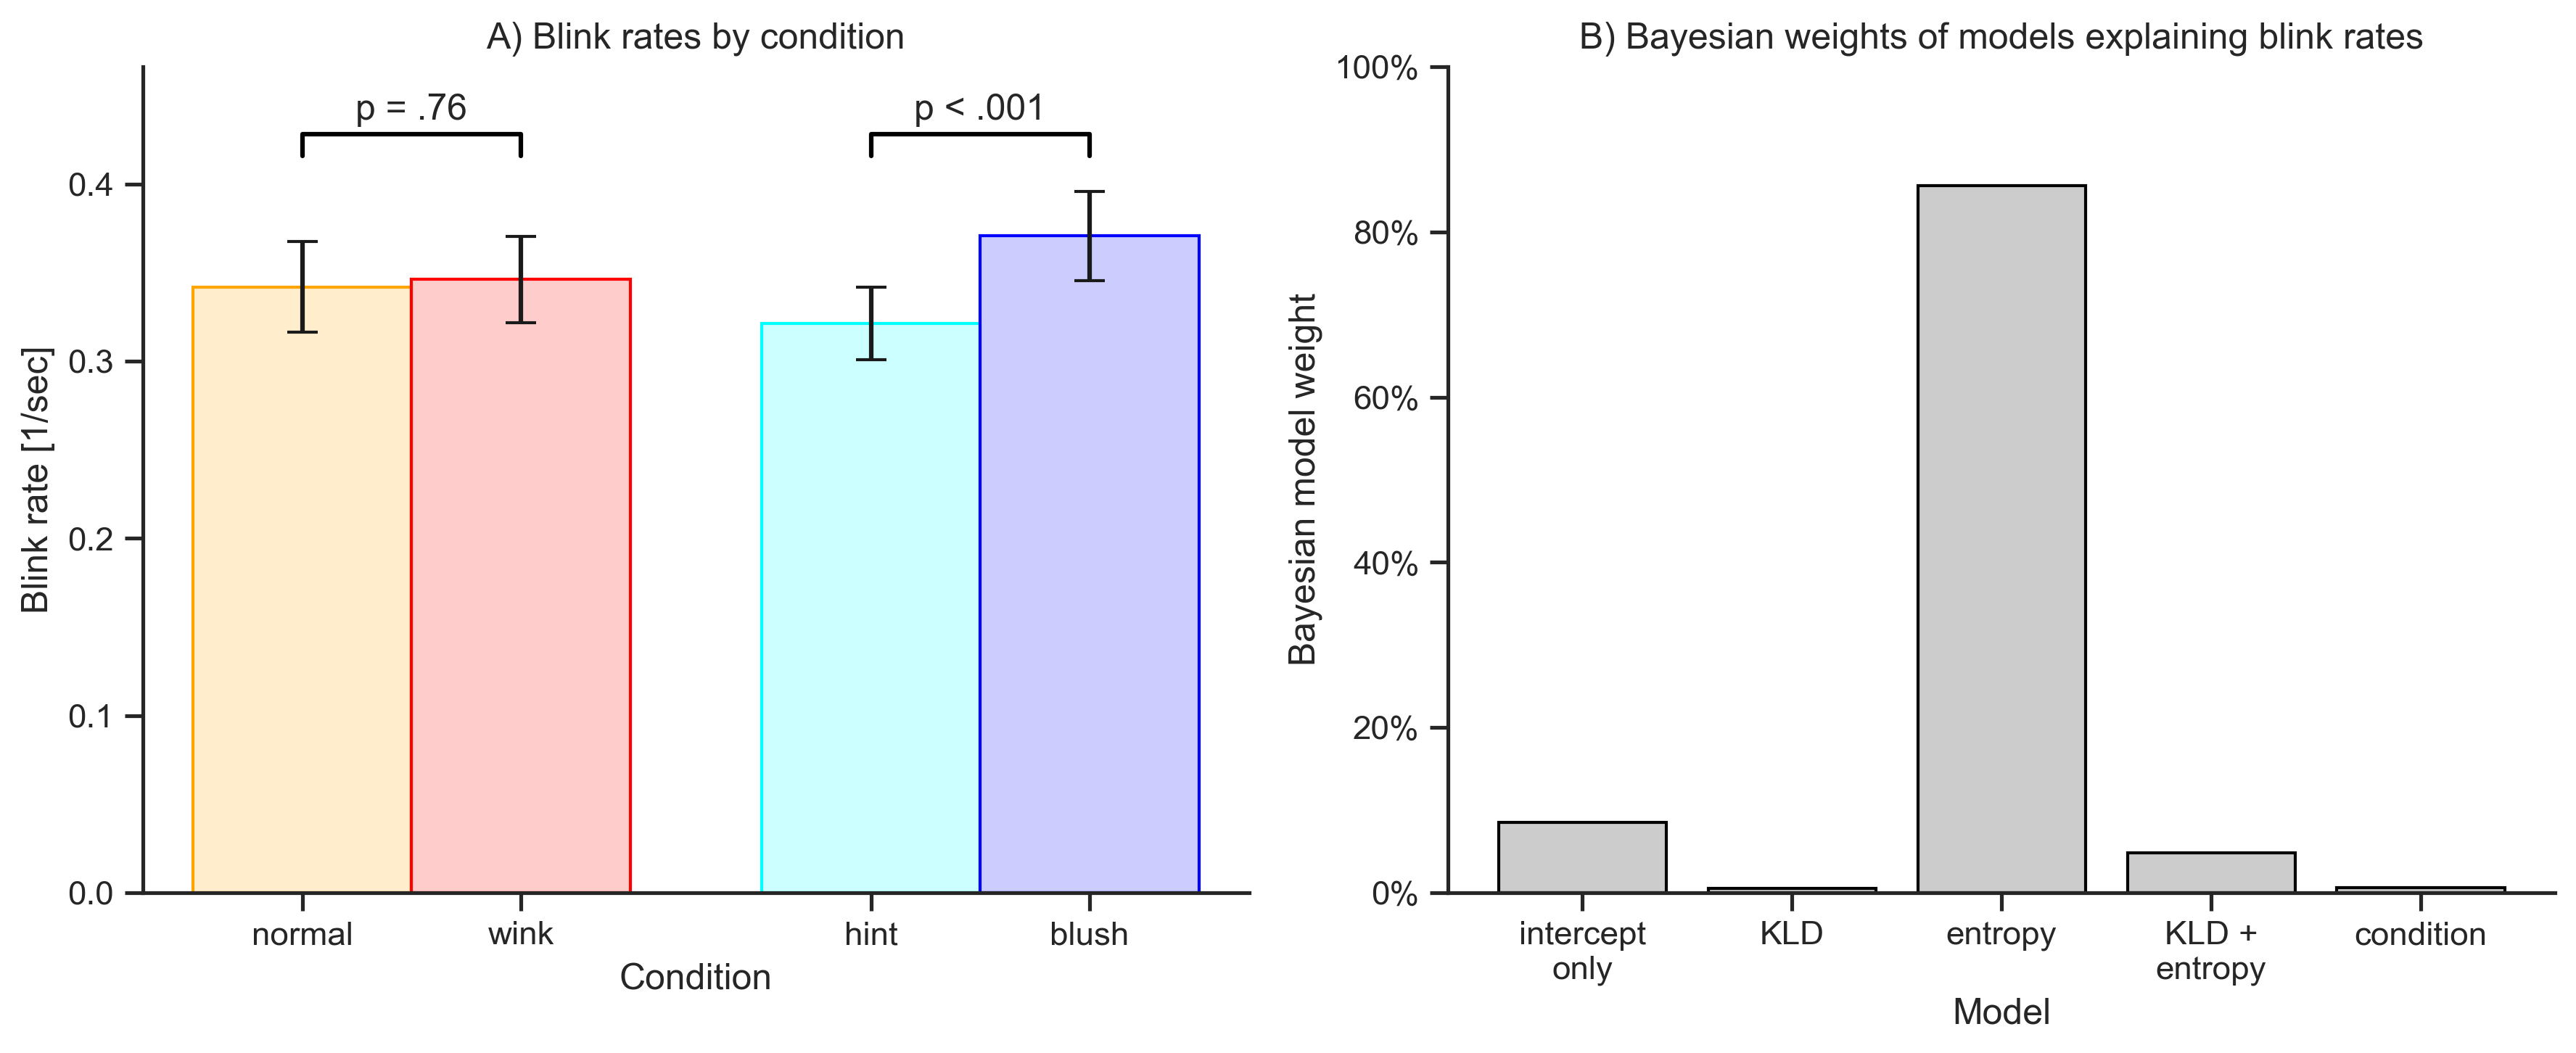

In [15]:
combinedBlinkPlot(blinkRates)